In [1]:
import warnings
from dataclasses import replace

warnings.filterwarnings("ignore")

import numpy as np

from scripts.helpers import run_experiment
from scripts.propensity import get_propensity_scores
from variables.variables import *
from scripts.matching import *
from scripts.plot import *
from variables.labels import *

from tqdm import tqdm

In [3]:
cfg = replace(
    BASE_CONFIG,
    method='quantile',
    limit=None,
    quantile=0.3
)
print(f"Running analysis of {cfg.__dict__['quantile']} quantile")

Running analysis of 0.3 quantile


In [4]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests


def matching_plot_error_bars_new(
    df_bootstrap,  # results_df from matching pipeline
    treated_title: str,  # exposure key (e.g., "fiber_density_energy_target_day")
    dir: str,  # legacy / fallback output directory
    experiment_id=None,
    target_title: str = "Treatment",
    alpha: float = 0.05,
    figsize=(8,8),
    out_dir=None,
    *,
    labels_dict=labels_dict,                # maps outcome col -> pretty label
    diet_short_names_mapping=diet_full_names_mapping,   # maps exposure key -> short title
    outcome_col: str = "outcome",
    xlim=None,                       # e.g., (-25, 25). If None -> dynamic
    show_annotations: bool = True,   # turn off for super-clean figures
    text_above_offset: float = 0.28, 
):
    """
    Publication-ready forest plot for matching results (ATE + CI + BH-adjusted p).

    - y-axis labels are replaced using labels_dict if provided
    - title is taken from diet_short_names_mapping if provided (fallback: treated_title)
    - styling is improved for paper-ready output
    """

    df_bootstrap = df_bootstrap.copy()

    labels_dict = {} if labels_dict is None else dict(labels_dict)
    diet_short_names_mapping = {} if diet_short_names_mapping is None else dict(diet_short_names_mapping)

    # ------------------ pick which columns to plot ------------------
    use_pct = all(c in df_bootstrap.columns for c in ["ATE_pct", "CI_low_pct", "CI_high_pct", "p_value_pct"])
    use_abs = all(c in df_bootstrap.columns for c in ["ATE", "CI_low", "CI_high", "p_value"])

    if not (use_pct or use_abs):
        raise KeyError(
            "df_bootstrap must contain either "
            "['ATE_pct','CI_low_pct','CI_high_pct','p_value_pct'] "
            "or ['ATE','CI_low','CI_high','p_value']."
        )

    if use_pct:
        eff_col, lo_col, hi_col, p_col = "ATE_pct", "CI_low_pct", "CI_high_pct", "p_value_pct"
        x_label = "Effect (% difference vs matched controls)"
        plot_mode = "pct"
    else:
        eff_col, lo_col, hi_col, p_col = "ATE", "CI_low", "CI_high", "p_value"
        x_label = "Effect (absolute difference)"
        plot_mode = "abs"

    # ------------------ try to find a control mean (optional; for annotation) ------------------
    control_mean_candidates = [
        "control_mean", "mean_control", "matched_control_mean", "control_mean_matched",
        "y0_mean", "outcome_mean_control", "ref_control_mean"
    ]
    control_mean_col = next((c for c in control_mean_candidates if c in df_bootstrap.columns), None)

    # Unified annotation columns: abs + %
    df_bootstrap["ATE_abs_for_annot"] = np.nan
    df_bootstrap["Effect_pct_for_annot"] = np.nan

    if plot_mode == "abs":
        df_bootstrap["ATE_abs_for_annot"] = df_bootstrap["ATE"].astype(float)
        if control_mean_col is not None:
            denom = df_bootstrap[control_mean_col].astype(float)
            with np.errstate(divide="ignore", invalid="ignore"):
                df_bootstrap["Effect_pct_for_annot"] = 100.0 * df_bootstrap["ATE_abs_for_annot"] / denom
    else:
        df_bootstrap["Effect_pct_for_annot"] = df_bootstrap["ATE_pct"].astype(float)
        if control_mean_col is not None:
            denom = df_bootstrap[control_mean_col].astype(float)
            df_bootstrap["ATE_abs_for_annot"] = (df_bootstrap["Effect_pct_for_annot"] / 100.0) * denom

    # ------------------ BH correction ------------------
    raw_pvals = df_bootstrap[p_col].to_numpy(dtype=float)
    ok = np.isfinite(raw_pvals)
    adj = np.full_like(raw_pvals, np.nan, dtype=float)
    if ok.sum() > 0:
        adj[ok] = multipletests(
            raw_pvals[ok],
            alpha=alpha,
            method="fdr_bh",
            maxiter=1,
            is_sorted=False,
            returnsorted=False,
        )[1]

    df_bootstrap["p_value_adj_bh"] = adj
    df_bootstrap["is_significant_bh"] = df_bootstrap["p_value_adj_bh"] < alpha

    # ------------------ prep labels + order ------------------
    outcomes_raw = df_bootstrap[outcome_col].astype(str).tolist()

    # Replace y labels using labels_dict
    def _pretty_outcome(o: str) -> str:
        # labels_dict in your project usually maps outcome variable -> nice label
        return labels_dict.get(o, o)

    outcomes_pretty = [_pretty_outcome(o) for o in outcomes_raw]

    m = len(outcomes_raw)
    y = np.arange(m)[::-1]  # top-to-bottom

    # ------------------ values ------------------
    eff = df_bootstrap[eff_col].to_numpy(dtype=float)
    lo = df_bootstrap[lo_col].to_numpy(dtype=float)
    hi = df_bootstrap[hi_col].to_numpy(dtype=float)
    p_adj = df_bootstrap["p_value_adj_bh"].to_numpy(dtype=float)
    is_sig = df_bootstrap["is_significant_bh"].to_numpy(dtype=bool)

    abs_ate = df_bootstrap["ATE_abs_for_annot"].to_numpy(dtype=float)
    pct_eff = df_bootstrap["Effect_pct_for_annot"].to_numpy(dtype=float)

    # ------------------ styling (paper-ready defaults) ------------------
    # Use conservative grayscale + accent for sig
    c_sig = "#C62828"     # deep red
    c_nonsig = "#9E9E9E"  # gray
    c_text = "#2b2b2b"

    point_size = 42
    ci_lw = 3.2
    cap_h = 0.12
    y_text_offset = 0.18

    # Figure size adapts to number of rows
    height = max(4.8, 0.55 * m)
    fig, ax = plt.subplots(figsize=figsize)

    # Vertical null line + light x-grid
    ax.axvline(0.0, linestyle="--", linewidth=1.2, color="#7a7a7a", alpha=0.75, zorder=0)
    ax.grid(axis="x", linewidth=0.6, alpha=0.25)
    ax.set_axisbelow(True)

    # ------------------ draw CI bars + caps ------------------
    for j in range(m):
        if not (np.isfinite(lo[j]) and np.isfinite(hi[j]) and np.isfinite(eff[j])):
            continue
        c = c_sig if bool(is_sig[j]) else c_nonsig
        ax.hlines(y[j], lo[j], hi[j], lw=ci_lw, color=c, zorder=2, capstyle="round")
        ax.plot([lo[j], lo[j]], [y[j] - cap_h, y[j] + cap_h], color=c, lw=ci_lw, zorder=2)
        ax.plot([hi[j], hi[j]], [y[j] - cap_h, y[j] + cap_h], color=c, lw=ci_lw, zorder=2)

    # Point estimates
    ax.scatter(eff, y, s=point_size, color="black", zorder=3)

    # ------------------ annotations ------------------
    def _fmt_p(p: float) -> str:
        if not np.isfinite(p):
            return "BH p=NA"
        if p < 0.001:
            return "BH p<0.001"
        return f"BH p={p:.3f}"

    def _fmt_abs(x: float) -> str:
        if not np.isfinite(x):
            return "ATE=NA"
        return f"ATE={x:+.2g}"

    def _fmt_pct(x: float) -> str:
        if not np.isfinite(x):
            return "Δ=NA"
        return f"Δ={x:+.1f}%"

    if show_annotations:
        # Put annotation near the CI end (cleaner than under the dot)
        # Choose right side unless it would go out of bounds
        # (xlim will be set after; we do a first-pass placement using CI bounds)
        for j in range(m):
            # (2) annotate only if BH p < alpha
            if not (np.isfinite(p_adj[j]) and (p_adj[j] < alpha)):
                continue

            text = f"{_fmt_p(p_adj[j])} • {_fmt_abs(abs_ate[j])} • {_fmt_pct(pct_eff[j])}"

            # (1) put annotation ABOVE the CI (centered)
            # Use midpoint of CI if finite; else fall back to eff
            if np.isfinite(lo[j]) and np.isfinite(hi[j]):
                x_text = 0.5 * (lo[j] + hi[j])
            else:
                x_text = eff[j]

            ax.text(
                x_text,
                y[j] + text_above_offset,
                text,
                ha="center",
                va="bottom",
                fontsize=10,
                color=c_text,
                alpha=0.95,
                clip_on=False,
                zorder=4,
            )

    # ------------------ axes cosmetics ------------------
    # Title from diet_short_names_mapping
    exposure_title = diet_short_names_mapping.get(treated_title, treated_title)
    
    ax.set_title(
        f"{exposure_title}",
        fontsize=14,
        pad=12,
    )
    ax.set_xlabel(x_label, fontsize=12)

    ax.set_yticks(y)
    ax.set_yticklabels(outcomes_pretty, fontsize=11)

    # x-limits: dynamic unless user sets xlim
    ax.set_xlim(-30, 30)

    # tidy spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#9a9a9a")
    ax.spines["bottom"].set_color("#9a9a9a")

    ax.set_ylim(-0.5, m - 0.5)
    plt.tight_layout()
    plt.grid(False)

    # ------------------ save ------------------
    final_out_dir = Path(out_dir) if out_dir is not None else Path(dir)
    final_out_dir.mkdir(parents=True, exist_ok=True)

    safe_title = treated_title
    prefix = "" #if experiment_id is None else f"{experiment_id}_"
    out_path = final_out_dir / f"{prefix}{safe_title}.png"

    fig.savefig(out_path, bbox_inches="tight", dpi=300)
    plt.close(fig)

    return out_path

In [5]:
from pathlib import Path
import pandas as pd

# Where to save the log
log_dir = Path(matching_folder_path_quantile)
log_dir.mkdir(parents=True, exist_ok=True)
log_csv_path = log_dir / "matching_meta_log.csv"

df_dir = Path(matching_df_folder_path)
df_dir.mkdir(parents=True, exist_ok=True)

meta_rows = []

for exposure in tqdm(EXPOSURES_SHORTLISTED):

    df, kwargs, X, shap_values = get_propensity_scores(
        exposure=exposure,
        config=cfg.__dict__,
        variables=variable_config,
        file=DATAFRAME_PATH,
    )

    exposure_baseline = exposure.split("_target_day")[0]

    results_df, matched_df, balance_df, meta = estimate_ate_matching_pipeline_cuped(
        df=df,
        variable_config=variable_config,
        treat_col="treated",
        ps_col="calibrated_scores_logreg",
        match_covariates=["gender", "bmi",], #[exposure_baseline, "gender", "bmi",],  # adjust if needed
        caliper=0.15,
        replace=False, #False,
        alpha=0.05,
        seed=0,
    )
    
    results_df.to_csv(f"{df_dir}/{exposure_baseline}_results.csv")
    balance_df.to_csv(f"{df_dir}/{exposure_baseline}_balance.csv")

    # ---- collect the fields you care about (plus a couple helpful ones) ----
    meta_rows.append({
        "exposure": exposure,
        "exposure_baseline": exposure_baseline,

        # matching size / reuse
        "n_pairs": meta.get("n_pairs", pd.NA),
        "n_treated_matched": meta.get("n_treated_matched", pd.NA),
        "n_controls_matched": meta.get("n_controls_matched", pd.NA),
        "unique_controls_used": meta.get("unique_controls_used", pd.NA),
        "controls_reused": meta.get("controls_reused", pd.NA),

        # balance summary (post)
        "mean_abs_SMD_post": meta.get("mean_abs_SMD_post", pd.NA),
        "median_abs_SMD_post": meta.get("median_abs_SMD_post", pd.NA),
        "p75_abs_SMD_post": meta.get("p75_abs_SMD_post", pd.NA),
        "max_abs_SMD_post": meta.get("max_abs_SMD_post", pd.NA),
        "median_abs_SMD_post_OK": meta.get("median_abs_SMD_post_OK", pd.NA),

        # NEW: list of confounders failing ASMD threshold
        "asmd_fail_count": meta.get("asmd_fail_count", pd.NA),
        "asmd_fail_features": meta.get("asmd_fail_features", ""),

        # run params
        "caliper": meta.get("caliper", pd.NA),
        "replace": meta.get("replace", pd.NA),
        "smd_threshold": meta.get("smd_threshold", pd.NA),
        "seed": meta.get("seed", pd.NA),
        "match_covariates": meta.get("match_covariates", ""),
    })

    # Plot + save (your function should save and return a Path)
    out_path = matching_plot_error_bars_new(
        df_bootstrap=results_df,
        treated_title=exposure_baseline,
        figsize=(10,8),
        dir=None,  # not used if you use out_dir inside your function
        #experiment_id="matching_ps_age_sex_bmi",
        target_title="Treatment",
        alpha=0.05,
        out_dir=matching_folder_path_quantile,
    )

# ---- write the log once at the end (stable ordering + nice formatting) ----
meta_log_df = pd.DataFrame(meta_rows)

cols = [
    "exposure", "exposure_baseline",

    "n_pairs", "n_treated_matched", "n_controls_matched",
    "unique_controls_used", "controls_reused",

    "mean_abs_SMD_post", "median_abs_SMD_post", "p75_abs_SMD_post", "max_abs_SMD_post",
    "median_abs_SMD_post_OK",

    "asmd_fail_count", "asmd_fail_features",

    "caliper", "replace", "smd_threshold", "seed", "match_covariates",
]
meta_log_df = meta_log_df[[c for c in cols if c in meta_log_df.columns]]

for c in ["mean_abs_SMD_post", "median_abs_SMD_post", "p75_abs_SMD_post", "max_abs_SMD_post"]:
    if c in meta_log_df.columns:
        meta_log_df[c] = pd.to_numeric(meta_log_df[c], errors="coerce").round(3)
        
meta_log_df.to_csv(log_csv_path, index=False)
print(f"Saved matching meta log to: {log_csv_path}")


100%|██████████| 12/12 [03:05<00:00, 15.43s/it]

Saved matching meta log to: results_matching/charts_quantile/matching_meta_log.csv


In [6]:
import pandas as pd

pd.set_option("display.max_colwidth", None)   # show full strings
pd.set_option("display.max_columns", None)    # show all columns
pd.set_option("display.width", 0)    

In [7]:
import pandas as pd

meta = pd.read_csv(f'{log_dir}/matching_meta_log.csv')
meta[[
    "exposure_baseline", "n_pairs", 
    "mean_abs_SMD_post", "max_abs_SMD_post",
    "asmd_fail_count", "asmd_fail_features",
]]

,exposure_baseline,n_pairs,mean_abs_SMD_post,max_abs_SMD_post,asmd_fail_count,asmd_fail_features
0,hours_to_sleep,328,0.072,0.154,5,age; heart_rate_mean_during_sleep; percent_of_rem_sleep_time; total_energy_kcal; percent_of_light_sleep_time
1,eating_window_h,303,0.051,0.125,1,total_energy_kcal
2,night_calories_pct,329,0.076,0.145,6,total_energy_kcal; total_sleep_time_minutes; percent_of_light_sleep_time; sleep_hour; percent_of_deep_sleep_time; number_of_wakes
3,plant_based_whole_foods_ratio,267,0.058,0.121,4,sleep_hour; total_energy_kcal; percent_of_rem_sleep_time; age
4,furits_and_veggies_energy_ratio,298,0.030,0.080,0,NaN
5,whole_food_categories_ratio,294,0.068,0.182,2,heart_rate_mean_during_sleep; total_energy_kcal
6,whole_dairy_categories_ratio,310,0.058,0.124,3,percent_of_rem_sleep_time; total_sleep_time_minutes; total_wake_time_after_sleep_onset_minutes
7,meat_and_poultry_energy_ratio,418,0.039,0.167,1,sleep_latency_minutes
8,processed_categories_ratio,322,0.066,0.189,4,percent_of_light_sleep_time; percent_of_rem_sleep_time; percent_of_deep_sleep_time; total_energy_kcal
9,animal_based_whole_foods_ratio,290,0.079,0.184,6,sleep_efficiency; sleep_latency_minutes; total_sleep_time_minutes; number_of_wakes; age; total_wake_time_after_sleep_onset_minutes


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Dict, Optional, Sequence

def plot_combined_matching_ipw_results(
    feature: str,
    labels_dict: Dict[str, str],
    annotation_dict: Optional[Dict[str, str]] = None,
    sig_thresh: float = 0.05,
    figsize_per_panel=(9, 7),
    point_size: float = 50.0,
    ci_line_width: float = 3.5,
    cap_height: float = 0.15,
    fontzise=14,
):
    """
    Loads matching and IPW data for a feature and plots them on one forest plot.
    Styling: Red if p < sig_thresh, Grey otherwise.
    """
    # 1. Load Datasets
    path_matching = f"results_matching/dataframes/{feature}_results.csv"
    path_ipw = f"results/dataframes/{feature}_ate.csv"
    
    df_matching_raw = pd.read_csv(path_matching)
    df_ipw_raw = pd.read_csv(path_ipw)

    # 2. Filter for pre-defined outcomes and standardize columns
    # We only care about outcomes present in labels_dict keys
    target_outcomes = list(labels_dict.keys())
    
    def prep_df(df, mapping):
        d = df[df['outcome'].isin(target_outcomes)].copy()
        d = d.rename(columns=mapping)
        return d.set_index('outcome')

    # Column mapping to harmonize df_matching and df_ipw
    map_matching = {
        "ATE_pct": "effect", 
        "CI_low_pct": "ci_low", 
        "CI_high_pct": "ci_high", 
        "p_value_pct": "p",
        "ATE": "ate_abs"
    }
    map_ipw = {
        "ATE_pct_point": "effect", 
        "CI_pct_2.5": "ci_low", 
        "CI_pct_97.5": "ci_high", 
        "p_value_boot_abs": "p",
        "ATE_abs_point": "ate_abs"
    }

    df_m = prep_df(df_matching_raw, map_matching)
    df_i = prep_df(df_ipw_raw, map_ipw)

    # 3. Plotting Setup
    outcomes = [o for o in target_outcomes if o in df_m.index or o in df_i.index]
    ylabels = [labels_dict.get(o, o) for o in outcomes]
    m = len(outcomes)
    
    outcome_gap = 2.0
    y_base = np.arange(m) * outcome_gap
    offsets = [-0.3, 0.3]  # Matching on top, IPW on bottom for each outcome
    methods = [("Matching", df_m, "#E31A1C"), ("IPW", df_i, "#1F78B4")]

    fig, ax = plt.subplots(figsize=figsize_per_panel)
    ax.axvline(0.0, linestyle="--", linewidth=1.2, color="#8a8a8a", alpha=0.8)

    # 4. Draw Loops
    for idx, (method_name, data, base_color) in enumerate(methods):
        d = data.reindex(outcomes)
        y = y_base + offsets[idx]
        
        eff = d["effect"].values
        lo = d["ci_low"].values
        hi = d["ci_high"].values
        pvals = d["p"].values
        abs_vals = d["ate_abs"].values

        for j in range(m):
            if np.isnan(eff[j]): continue
            
            # Determine color based on significance
            is_sig = pvals[j] < sig_thresh
            color = base_color if is_sig else "#9E9E9E"
            
            # Draw CI
            ax.hlines(y[j], lo[j], hi[j], lw=ci_line_width, color=color, zorder=2)
            ax.plot([lo[j], lo[j]], [y[j]-cap_height, y[j]+cap_height], color=color, lw=ci_line_width)
            ax.plot([hi[j], hi[j]], [y[j]-cap_height, y[j]+cap_height], color=color, lw=ci_line_width)
            
            # Draw Point
            ax.scatter(eff[j], y[j], s=point_size, color="black", edgecolors="white", zorder=3)

            # Annotate if significant (using logic from your provided function)
            if is_sig:
                units = annotation_dict.get(outcomes[j], "") if annotation_dict else ""
                sign = "+" if abs_vals[j] > 0 else ""
                txt = f"{sign}{abs_vals[j]:.1f} {units} ({eff[j]:+.1f}%)"
                
                ax.text(eff[j], y[j] - 0.2, txt, ha="center", va="bottom", fontsize=fontzise, fontweight='bold', color="#333")

    # 5. Styling
    ax.set_yticks(y_base)
    ax.set_yticklabels(ylabels, fontsize=fontzise)
    ax.invert_yaxis()
    ax.set_xlabel("Effect (% point difference)", fontsize=fontzise)
    ax.set_title(f"Treatment Effects for {feature.replace('_', ' ').title()}", pad=20)
    ax.set_xlim(-25, 25)
    
    # Legend for methods
    handles = [plt.Line2D([0], [0], color="#E31A1C", lw=2, label='Top and Bottom 30% Matching'),
    plt.Line2D([0], [0], color="#1F78B4", lw=2, label='IPW')]
    ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)

    for spine in ["top", "right"]: ax.spines[spine].set_visible(False)
    plt.tight_layout()
    #plt.show()
    
    return fig, ax

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Optional

def plot_combined_matching_ipw_results(
    feature: str,
    labels_dict: Dict[str, str],
    annotation_dict: Dict[str, str],
    diet_full_names_mapping: Dict[str, str],
    sig_thresh: float = 0.05,
    figsize_per_panel=(7, 8),
    point_size: float = 60.0,
    ci_line_width: float = 4.0,
    cap_height: float = 0.15,
):
    """
    Plots Matching and IPW results on a single forest plot.
    Font sizes are standardized to 14 for all elements.
    Significant results are highlighted and annotated with units.
    """
    # 1. Load Datasets
    path_matching = f"results_matching/dataframes/{feature}_results.csv"
    path_ipw = f"results/dataframes/{feature}_ate.csv"
    
    df_matching_raw = pd.read_csv(path_matching)
    df_ipw_raw = pd.read_csv(path_ipw)

    # 2. Filter for pre-defined outcomes and harmonize columns
    target_outcomes = list(labels_dict.keys())
    
    def prep_df(df, mapping):
        d = df[df['outcome'].isin(target_outcomes)].copy()
        d = d.rename(columns=mapping)
        return d.set_index('outcome')

    map_matching = {
        "ATE_pct": "effect", "CI_low_pct": "ci_low", "CI_high_pct": "ci_high", 
        "p_value_pct": "p", "ATE": "ate_abs"
    }
    map_ipw = {
        "ATE_pct_point": "effect", "CI_pct_2.5": "ci_low", "CI_pct_97.5": "ci_high", 
        "p_value_boot_abs": "p", "ATE_abs_point": "ate_abs"
    }

    df_m = prep_df(df_matching_raw, map_matching)
    df_i = prep_df(df_ipw_raw, map_ipw)

    # 3. Plotting Setup
    outcomes = [o for o in target_outcomes if o in df_m.index or o in df_i.index]
    ylabels = [labels_dict.get(o, o) for o in outcomes]
    feature_title = diet_full_names_mapping.get(feature, feature)
    
    m = len(outcomes)
    outcome_gap = 2.5
    y_base = np.arange(m) * outcome_gap
    offsets = [-0.4, 0.4] 
    methods = [("Matching", df_m, "#E31A1C"), ("IPW", df_i, "#1F78B4")]

    fig, ax = plt.subplots(figsize=figsize_per_panel)
    ax.axvline(0.0, linestyle="--", linewidth=1.5, color="#8a8a8a", alpha=0.8)

    # 4. Drawing Logic
    for idx, (method_name, data, base_color) in enumerate(methods):
        d = data.reindex(outcomes)
        y = y_base + offsets[idx]
        
        eff = d["effect"].values
        lo = d["ci_low"].values
        hi = d["ci_high"].values
        pvals = d["p"].values
        abs_vals = d["ate_abs"].values

        for j in range(m):
            if np.isnan(eff[j]): continue
            
            is_sig = pvals[j] < sig_thresh
            color = base_color if is_sig else "#9E9E9E"
            
            # Draw CI and Caps
            ax.hlines(y[j], lo[j], hi[j], lw=ci_line_width, color=color, zorder=2)
            ax.plot([lo[j], lo[j]], [y[j]-cap_height, y[j]+cap_height], color=color, lw=ci_line_width)
            ax.plot([hi[j], hi[j]], [y[j]-cap_height, y[j]+cap_height], color=color, lw=ci_line_width)
            
            # Draw Point Estimate
            ax.scatter(eff[j], y[j], s=point_size, color="black", edgecolors="white", zorder=3)

            # Annotations for significant effects
            if is_sig:
                unit = annotation_dict.get(outcomes[j], "")
                # Ensure a space only if there is a unit string
                unit_str = f" {unit}" if unit else ""
                sign = "+" if abs_vals[j] > 0 else ""
                
                # Format: +14.2 min (+5.1%)
                txt = f"{sign}{abs_vals[j]:.1f}{unit_str} ({eff[j]:+.1f}%)"
                
                ax.text(eff[j], y[j] - 0.25, txt, ha="center", va="bottom", 
                        fontsize=14, fontweight='bold', color="#333", clip_on=False)

    # 5. Final Styling (All font sizes set to 14)
    ax.set_yticks(y_base)
    ax.set_yticklabels(ylabels, fontsize=14)
    ax.invert_yaxis()
    
    ax.set_xlabel("Effect (% point difference)", fontsize=14)
    ax.set_title(f"{feature_title}", fontsize=14, pad=30)
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Legend construction
    handles = [
        plt.Line2D([0], [0], color="#E31A1C", lw=3, label='Top and Bottom 30% Matching'),
        plt.Line2D([0], [0], color="#1F78B4", lw=3, label='IPW')
    ]
    ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2, frameon=False, fontsize=14)

    # Clean up spines
    for spine in ["top", "right"]: ax.spines[spine].set_visible(False)
    ax.spines["left"].set_color("gray")
    ax.spines["bottom"].set_color("gray")
    ax.set_xlim(-25, 25)

    plt.tight_layout()
    return fig, ax

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Optional

def plot_combined_matching_ipw_results(
    feature: str,
    labels_dict: Dict[str, str],
    annotation_dict: Dict[str, str],
    diet_full_names_mapping: Dict[str, str],
    sig_thresh: float = 0.05,
    figsize_per_panel=(8, 8),
    point_size: float = 60.0,
    ci_line_width: float = 4.0,
    cap_height: float = 0.15,
):
    # 1. Load Datasets
    path_matching = f"results_matching/dataframes/{feature}_results.csv"
    path_ipw = f"results/dataframes/{feature}_ate.csv"
    
    df_matching_raw = pd.read_csv(path_matching)
    df_ipw_raw = pd.read_csv(path_ipw)

    # 2. Keep outcomes in the EXACT order of labels_dict keys
    target_outcomes = list(labels_dict.keys())
    
    def prep_df(df, mapping):
        # Filter and rename, but we will reindex later to fix order
        d = df[df['outcome'].isin(target_outcomes)].copy()
        d = d.rename(columns=mapping)
        return d.set_index('outcome')

    map_matching = {
        "ATE_pct": "effect", "CI_low_pct": "ci_low", "CI_high_pct": "ci_high", 
        "p_value_pct_fdr_bh": "p", "ATE": "ate_abs"
    }
    map_ipw = {
        "ATE_pct_point": "effect", "CI_pct_2.5": "ci_low", "CI_pct_97.5": "ci_high", 
        "p_value_boot_abs": "p", "ATE_abs_point": "ate_abs"
    }

    df_m = prep_df(df_matching_raw, map_matching)
    df_i = prep_df(df_ipw_raw, map_ipw)

    # 3. Plotting Setup
    # This ensures the Y-axis follows your labels_dict order exactly
    outcomes = target_outcomes 
    ylabels = [labels_dict.get(o, o) for o in outcomes]
    feature_title = diet_full_names_mapping.get(feature, feature)
    
    m = len(outcomes)
    outcome_gap = 3.5  # Increased for less crowding
    y_base = np.arange(m) * outcome_gap
    offsets = [-0.5, 0.5] 
    methods = [("Matching", df_m, "#E31A1C"), ("IPW", df_i, "#1F78B4")]

    fig, ax = plt.subplots(figsize=figsize_per_panel)
    ax.axvline(0.0, linestyle="--", linewidth=1.5, color="#8a8a8a", alpha=0.8)

    # 4. Drawing Logic
    for idx, (method_name, data, base_color) in enumerate(methods):
        # Reindex here ensures the data matches the 'outcomes' order
        d = data.reindex(outcomes)
        y = y_base + offsets[idx]
        
        eff = d["effect"].values
        lo = d["ci_low"].values
        hi = d["ci_high"].values
        pvals = d["p"].values
        abs_vals = d["ate_abs"].values

        for j in range(m):
            if np.isnan(eff[j]): continue
            
            is_sig = pvals[j] < sig_thresh / 15
            color = base_color if is_sig else "#9E9E9E"
            
            # Draw CI and Caps
            ax.hlines(y[j], lo[j], hi[j], lw=ci_line_width, color=color, zorder=2)
            ax.plot([lo[j], lo[j]], [y[j]-cap_height, y[j]+cap_height], color=color, lw=ci_line_width)
            ax.plot([hi[j], hi[j]], [y[j]-cap_height, y[j]+cap_height], color=color, lw=ci_line_width)
            
            # Draw Point Estimate
            ax.scatter(eff[j], y[j], s=point_size, color="black", edgecolors="white", zorder=3)

            # 5. Right-Aligned Annotations (Less Crowded)
            if is_sig:
                unit = annotation_dict.get(outcomes[j], "")
                unit_str = f" {unit}" if unit else ""
                sign = "+" if abs_vals[j] > 0 else ""
                txt = f"{sign}{abs_vals[j]:.1f}{unit_str} ({eff[j]:+.1f}%)"
                
                # Places text at x=13 (outside the main plot area)
                ax.text(14, y[j], txt, ha="left", va="center", 
                        fontsize=14, fontweight='bold', color=color)

    # 6. Final Styling
    ax.set_yticks(y_base)
    ax.set_yticklabels(ylabels, fontsize=14)
    ax.set_xlim(-25, 25) # Expanded x-axis for labels
    ax.invert_yaxis()
    
    ax.set_xlabel("Effect (% point difference)", fontsize=14)
    feature_title = feature_title.replace('\n', ' ')
    ax.set_title(f"{feature_title}", fontsize=14, pad=60)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    handles = [
        plt.Line2D([0], [0], color="#E31A1C", lw=3, label='Top and Bottom 30% Matching'),
        plt.Line2D([0], [0], color="#1F78B4", lw=3, label='IPW')
    ]
    ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2, frameon=False, fontsize=14)

    for spine in ["top", "right"]: ax.spines[spine].set_visible(False)
    plt.tight_layout()
    return fig, ax

In [33]:
columns = [
    'fiber_density_energy',
    'hours_to_sleep',
    'plant_based_whole_foods_ratio',
    'processed_categories_ratio'
]

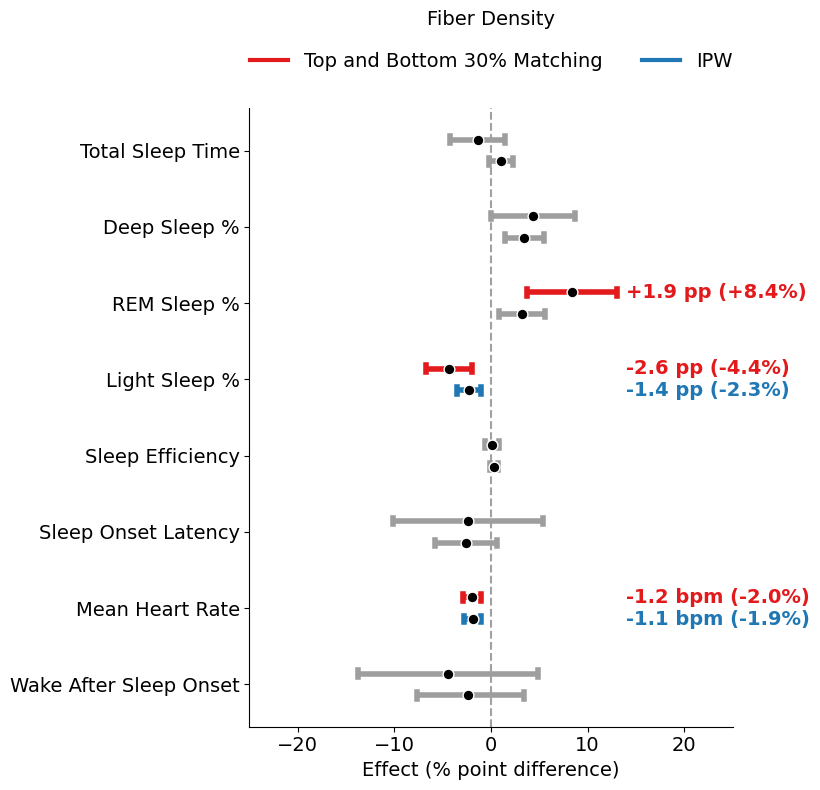

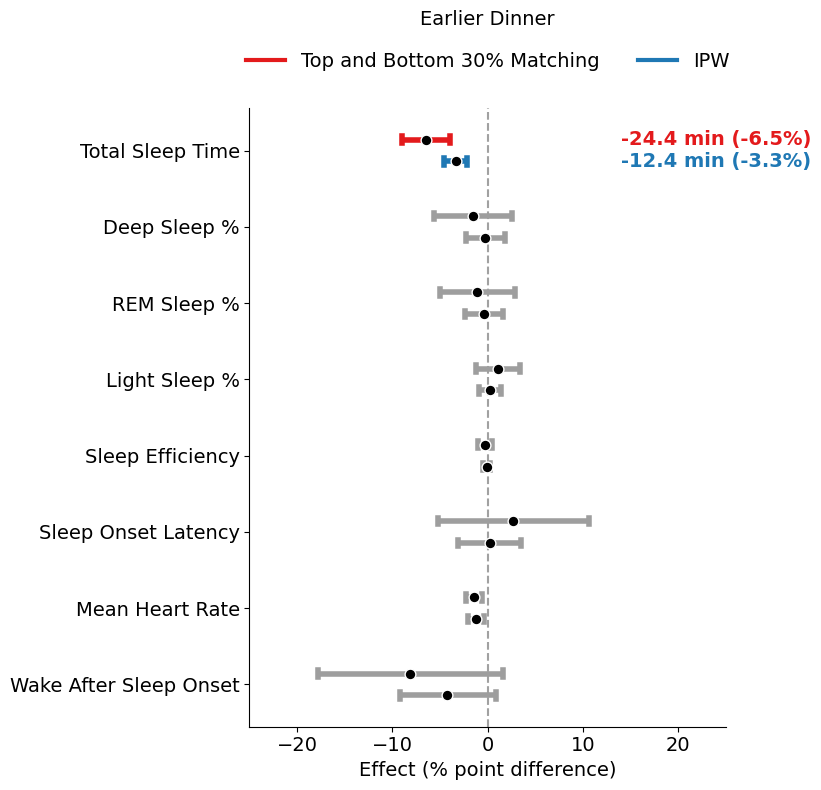

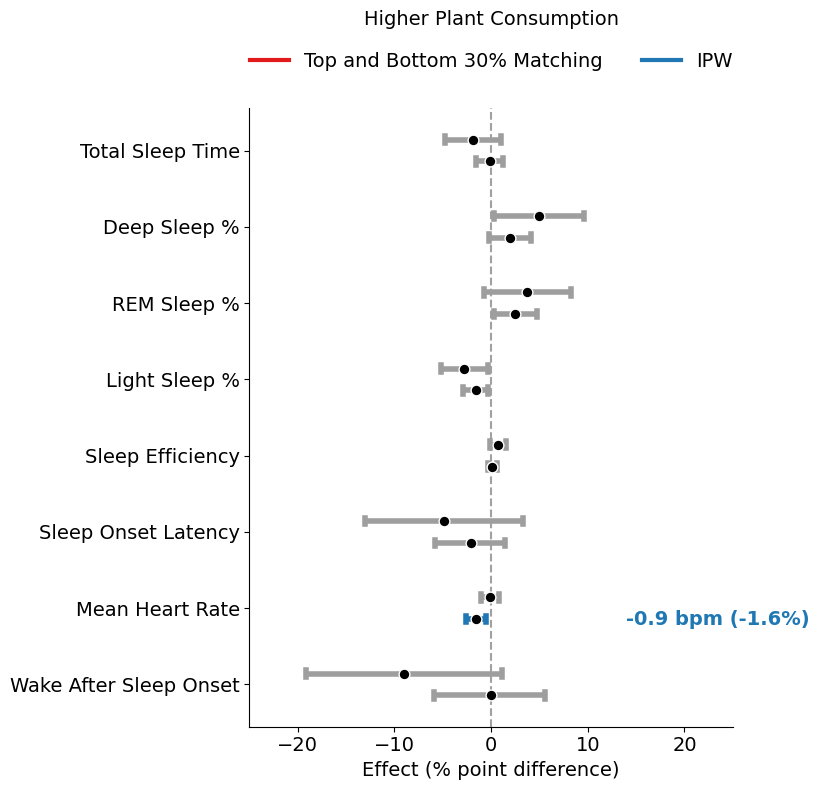

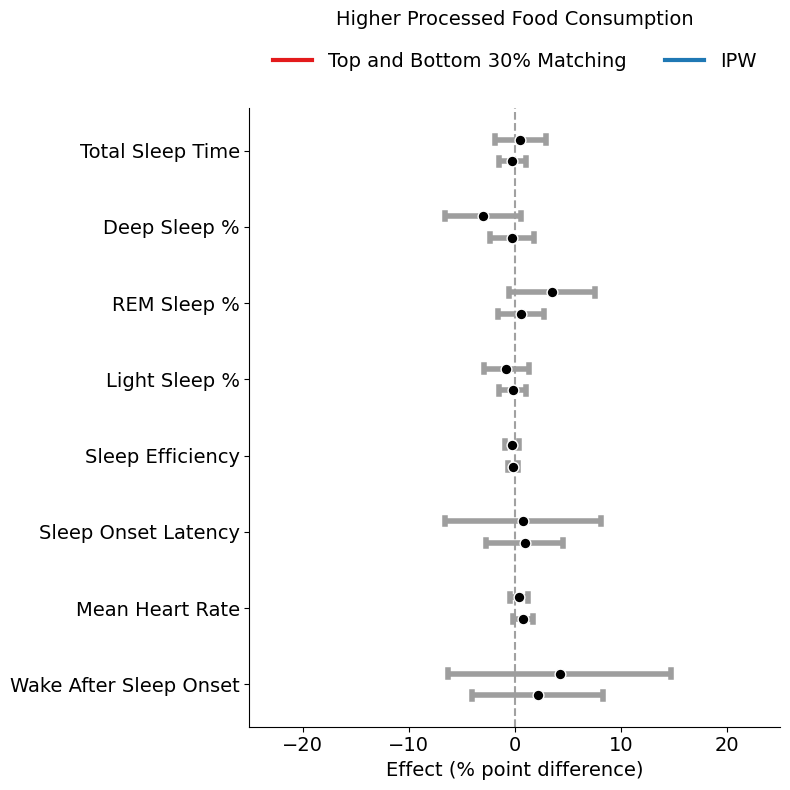

In [34]:
for c in columns:
    fig, ax = plot_combined_matching_ipw_results(
        c, 
        labels_dict=labels_dict,
        annotation_dict=annotation_dict,
        diet_full_names_mapping=diet_full_names_mapping
        )
    fig.show()

TypeError: plot_combined_matching_ipw_results() got an unexpected keyword argument 'ax'

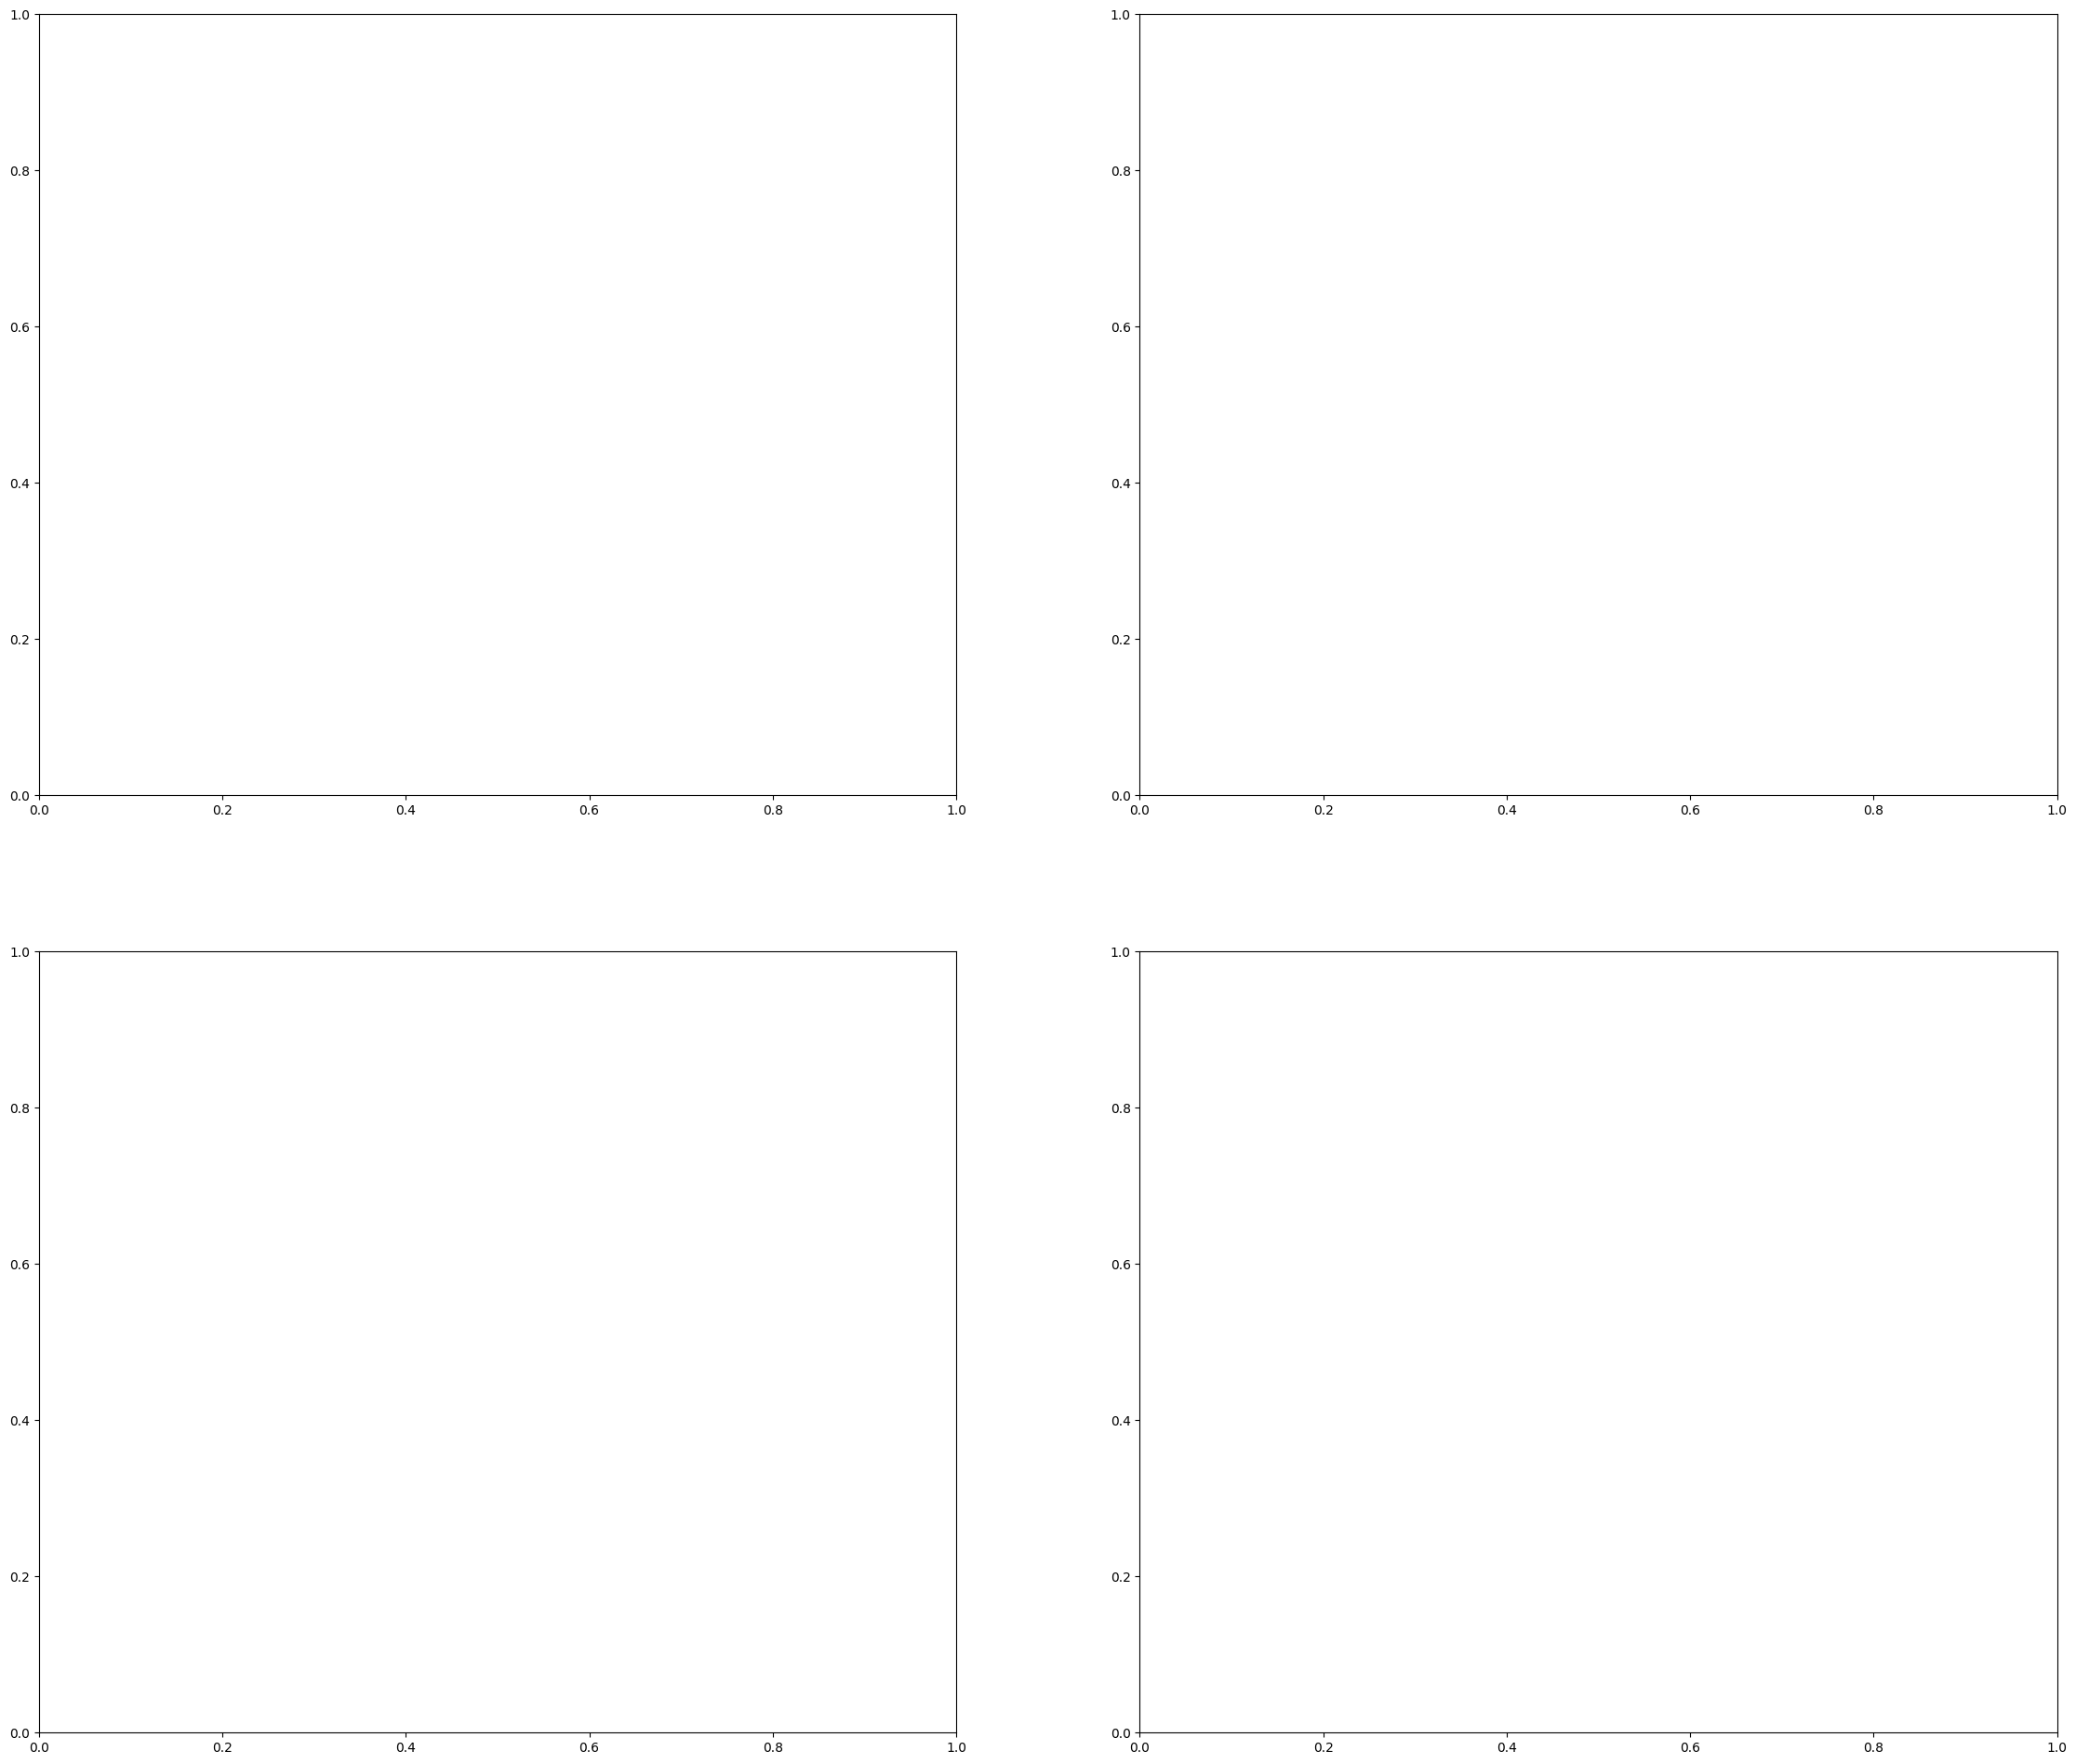

In [ ]:
import matplotlib.pyplot as plt

def plot_combined_grid(
    columns: list, 
    labels_dict: dict, 
    annotation_dict: dict, 
    diet_full_names_mapping: dict
):
    """
    Creates a 2x2 grid of forest plots for 4 specific features.
    """
    if len(columns) != 4:
        print("Warning: This function is optimized for exactly 4 columns.")

    # Create a 2x2 grid. Increase figsize for clarity.
    fig, axes = plt.subplots(2, 2, figsize=(28, 24))
    axes_flat = axes.flatten()

    for i, col_name in enumerate(columns):
        if i >= len(axes_flat):
            break
            
        # Call your existing function, passing the specific axis
        plot_combined_matching_ipw_results(
            col_name,
            labels_dict=labels_dict,
            annotation_dict=annotation_dict,
            diet_full_names_mapping=diet_full_names_mapping,
            ax=axes_flat[i]
        )

    # Global spacing adjustments
    plt.tight_layout(pad=10.0) # pad helps prevent overlap between subplots
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    return fig, axes

# Usage Example:
fig, axes = plot_combined_grid(columns, labels_dict, annotation_dict, diet_full_names_mapping)
plt.show()